In [203]:
from joblib import effective_n_jobs

In [204]:
from lshiftml.feature_utils.parallel import get_features_in_parallel
from rascal.representations import SphericalInvariants as SOAP
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from ase.io import read
import json
import numpy as np
from sklearn.model_selection import train_test_split
from loader.loader import load_data
from skcosmo.model_selection import atom_groups_by_frame

In [26]:
%pwd

'/ssd/scratch/kellner/COSMO_project/uncertainty'

In [205]:

train_structures, test_structures, train_properties, test_properties = load_data("/ssd/scratch/kellner/COSMO_project/make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz",\
                                                                                    "/ssd/scratch/kellner/COSMO_project/make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",selected_species=1)

with open("/ssd/scratch/kellner/ShiftML-Light/src/lshiftml/models/RR_model_data/RR_this_work_models/hypers/1_hypers.json","r") as fg:
                hypers = json.load(fg)

"""frames_train = read("../../COSMO_project/make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz",index=":",format="extxyz")
frames_test = read("../../COSMO_project/make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",index=":",format="extxyz")


tmp = []


for frame in frames:
    numbers = np.unique(frame.numbers)
    
    defined = True
    for number in numbers:
        if number not in [1,6,7,8,16]:
            defined = False
        else:
            continue
    
    if defined:
        tmp.append(frame)

frames = tmp

for frame in frames_train: frame.wrap(eps=1e-12)
for frame in frames_test: frame.wrap(eps=1e-12)

results_train = {}
for specie in [1,6,7,8]:
    tmp_array = []
    for frame in frames_train:
        mask_center_atoms_by_species(frame,species_select=[specie])
        tmp_array.append(frame.arrays["cs_iso"][frame.arrays["center_atoms_mask"]])
        del frame.arrays["center_atoms_mask"]
    results_train[specie] = np.hstack(tmp_array)

results_test = {}
for specie in [1,6,7,8]:
    tmp_array = []
    for frame in frames_test:
        mask_center_atoms_by_species(frame,species_select=[specie])
        tmp_array.append(frame.arrays["cs_iso"][frame.arrays["center_atoms_mask"]])
        del frame.arrays["center_atoms_mask"]
    results_test[specie] = np.hstack(tmp_array)
    

#feat
for frame in frames_train: mask_center_atoms_by_species(frame,species_select=[1])
for frame in frames_test: mask_center_atoms_by_species(frame,species_select=[1])

Ytrain = results_train[1]
Ytest = results_test[1]"""


Xtrain = get_features_in_parallel(train_structures,SOAP,hypers)
Xtest = get_features_in_parallel(test_structures,SOAP,hypers)
#predict

train_groups = atom_groups_by_frame(train_structures)
#Xtrain,Xtest,Ytrain,Ytest = train_test_split(Xpredict,results[1],train_size=0.75)

Ytrain = train_properties
Ytest = test_properties

In [32]:
model2 = Ridge(alpha=0.0001)
model2.fit(Xtrain,Ytrain)
ypred2 = model2.predict(Xtest)
rmse = mean_squared_error(ypred2,Ytest,squared=False)
print(rmse)

0.47999190465054636


In [19]:
Ytest

(35289,)

In [110]:
with open("/ssd/scratch/kellner/COSMO_project/uncertainty/multi_ridge_v2/1_0_hypers.json","r") as fg:
                hypers2 = json.load(fg)
with open("/ssd/scratch/kellner/COSMO_project/uncertainty/multi_ridge_v2/1_1_hypers.json","r") as fg:
                hypers3 = json.load(fg)


In [111]:
hypers3

{'soap_type': 'PowerSpectrum',
 'interaction_cutoff': 6.0162081478510965,
 'max_radial': 8,
 'max_angular': 8,
 'gaussian_sigma_constant': 0.2687521416964727,
 'gaussian_sigma_type': 'Constant',
 'radial_basis': 'GTO',
 'normalize': True,
 'cutoff_smooth_width': 0.3,
 'cutoff_function_type': 'RadialScaling',
 'optimization': {'RadialDimReduction': {'projection_matrices': {'1': [[[0.8400778931733396,
       0.4412173105917629,
       0.06881148411780058,
       0.02735917838695556,
       0.033139170964546126,
       0.0944783819045445,
       0.09592091750848371,
       0.13442216361470344,
       0.13684178826095786,
       0.11443806132332539,
       0.09166830222204785,
       0.07379121889846489,
       0.06320493598645305,
       0.05104630333945201,
       0.0406878705167208,
       0.036097824427603405,
       0.030537508857802317,
       0.021512204996477147,
       0.012464078083261573,
       0.006211645642714326],
      [0.253937928802236,
       0.13490852742353648,
       

In [109]:
hypers2

{'soap_type': 'PowerSpectrum',
 'interaction_cutoff': 6.0162081478510965,
 'max_radial': 8,
 'max_angular': 8,
 'gaussian_sigma_constant': 0.2687521416964727,
 'gaussian_sigma_type': 'Constant',
 'radial_basis': 'GTO',
 'normalize': True,
 'cutoff_smooth_width': 0.3,
 'cutoff_function_type': 'RadialScaling',
 'optimization': {'RadialDimReduction': {'projection_matrices': {'1': [[[0.8400778931733396,
       0.4412173105917629,
       0.06881148411780058,
       0.02735917838695556,
       0.033139170964546126,
       0.0944783819045445,
       0.09592091750848371,
       0.13442216361470344,
       0.13684178826095786,
       0.11443806132332539,
       0.09166830222204785,
       0.07379121889846489,
       0.06320493598645305,
       0.05104630333945201,
       0.0406878705167208,
       0.036097824427603405,
       0.030537508857802317,
       0.021512204996477147,
       0.012464078083261573,
       0.006211645642714326],
      [0.253937928802236,
       0.13490852742353648,
       

In [107]:
hypers

{'soap_type': 'PowerSpectrum',
 'interaction_cutoff': 6.0162081478510965,
 'max_radial': 8,
 'max_angular': 8,
 'gaussian_sigma_constant': 0.2687521416964727,
 'gaussian_sigma_type': 'Constant',
 'radial_basis': 'GTO',
 'normalize': True,
 'cutoff_smooth_width': 0.3,
 'cutoff_function_type': 'RadialScaling',
 'optimization': {'RadialDimReduction': {'projection_matrices': {'1': [[[0.8400778931733396,
       0.4412173105917629,
       0.06881148411780058,
       0.02735917838695556,
       0.033139170964546126,
       0.0944783819045445,
       0.09592091750848371,
       0.13442216361470344,
       0.13684178826095786,
       0.11443806132332539,
       0.09166830222204785,
       0.07379121889846489,
       0.06320493598645305,
       0.05104630333945201,
       0.0406878705167208,
       0.036097824427603405,
       0.030537508857802317,
       0.021512204996477147,
       0.012464078083261573,
       0.006211645642714326],
      [0.253937928802236,
       0.13490852742353648,
       

In [200]:
"""Bagging meta-estimator."""

# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause


import itertools
import numbers
import numpy as np
from abc import ABCMeta, abstractmethod
from warnings import warn
from functools import partial

from joblib import Parallel

from sklearn.ensemble._base import BaseEnsemble, _partition_estimators
from sklearn.base import ClassifierMixin, RegressorMixin
from sklearn.metrics import r2_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import check_random_state, column_or_1d, deprecated
from sklearn.utils import indices_to_mask
from sklearn.utils.metaestimators import available_if
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.random import sample_without_replacement
from sklearn.utils.validation import has_fit_parameter, check_is_fitted, _check_sample_weight
from sklearn.utils.fixes import delayed
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.validation import check_is_fitted
from sklearn.ensemble._base import _partition_estimators
from sklearn.ensemble._bagging import _parallel_predict_regression, BaseBagging
from joblib import Parallel
from sklearn.utils.fixes import delayed
from sklearn.base import ClassifierMixin, RegressorMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.linear_model import Ridge


__all__ = ["BaggingClassifier", "BaggingRegressor"]

MAX_INT = np.iinfo(np.int32).max


def _generate_indices(random_state, bootstrap, n_population, n_samples, groups=None):
    """Draw randomly sampled indices."""
    # Draw sample indices
    
    if groups is not None:
        
        frac = n_samples/n_population
        
        if bootstrap:
            group_labels = np.unique(groups)
            N_groups = len(group_labels)
            raise NotImplementedError
        
        else:
            splitter = GroupShuffleSplit(n_splits = 2, train_size=frac)
            dummy_ind = np.arange(n_population)
            indices, other = next(splitter.split(dummy_ind,dummy_ind,groups))
            
    else:
        if bootstrap:
            indices = random_state.randint(0, n_population, n_samples)
        else:
            indices = sample_without_replacement(
                n_population, n_samples, random_state=random_state
            )

    return indices


def _generate_bagging_indices(
    random_state,
    bootstrap_features,
    bootstrap_samples,
    n_features,
    n_samples,
    max_features,
    max_samples,
    groups
):
    """Randomly draw feature and sample indices."""
    # Get valid random state
    random_state = check_random_state(random_state)

    # Draw indices
    feature_indices = _generate_indices(
        random_state, bootstrap_features, n_features, max_features
    )
    sample_indices = _generate_indices(
        random_state, bootstrap_samples, n_samples, max_samples, groups
    )

    return feature_indices, sample_indices


def _parallel_build_estimators(
    n_estimators,
    ensemble,
    X,
    y,
    groups,
    sample_weight,
    seeds,
    total_n_estimators,
    verbose,
    check_input,
):
    """Private function used to build a batch of estimators within a job."""
    # Retrieve settings
    n_samples, n_features = X.shape
    max_features = ensemble._max_features
    max_samples = ensemble._max_samples
    bootstrap = ensemble.bootstrap
    bootstrap_features = ensemble.bootstrap_features
    support_sample_weight = has_fit_parameter(ensemble.base_estimator_, "sample_weight")
    has_check_input = has_fit_parameter(ensemble.base_estimator_, "check_input")
    if not support_sample_weight and sample_weight is not None:
        raise ValueError("The base estimator doesn't support sample weight")

    # Build estimators
    estimators = []
    estimators_features = []

    for i in range(n_estimators):
        if verbose > 1:
            print(
                "Building estimator %d of %d for this parallel run (total %d)..."
                % (i + 1, n_estimators, total_n_estimators)
            )

        random_state = seeds[i]
        estimator = ensemble._make_estimator(append=False, random_state=random_state)

        if has_check_input:
            estimator_fit = partial(estimator.fit, check_input=check_input)
        else:
            estimator_fit = estimator.fit

        # Draw random feature, sample indices
        features, indices = _generate_bagging_indices(
            random_state,
            bootstrap_features,
            bootstrap,
            n_features,
            n_samples,
            max_features,
            max_samples,
            groups
        )

        # Draw samples, using sample weights, and then fit
        if support_sample_weight:
            if sample_weight is None:
                curr_sample_weight = np.ones((n_samples,))
            else:
                curr_sample_weight = sample_weight.copy()

            if bootstrap:
                sample_counts = np.bincount(indices, minlength=n_samples)
                curr_sample_weight *= sample_counts
            else:
                not_indices_mask = ~indices_to_mask(indices, n_samples)
                curr_sample_weight[not_indices_mask] = 0

            estimator_fit(X[:, features], y, sample_weight=curr_sample_weight)

        else:
            estimator_fit(X[indices][:, features], y[indices])

        estimators.append(estimator)
        estimators_features.append(features)

    return estimators, estimators_features


def _parallel_predict_proba(estimators, estimators_features, X, n_classes):
    """Private function used to compute (proba-)predictions within a job."""
    n_samples = X.shape[0]
    proba = np.zeros((n_samples, n_classes))

    for estimator, features in zip(estimators, estimators_features):
        if hasattr(estimator, "predict_proba"):
            proba_estimator = estimator.predict_proba(X[:, features])

            if n_classes == len(estimator.classes_):
                proba += proba_estimator

            else:
                proba[:, estimator.classes_] += proba_estimator[
                    :, range(len(estimator.classes_))
                ]

        else:
            # Resort to voting
            predictions = estimator.predict(X[:, features])

            for i in range(n_samples):
                proba[i, predictions[i]] += 1

    return proba


def _parallel_predict_log_proba(estimators, estimators_features, X, n_classes):
    """Private function used to compute log probabilities within a job."""
    n_samples = X.shape[0]
    log_proba = np.empty((n_samples, n_classes))
    log_proba.fill(-np.inf)
    all_classes = np.arange(n_classes, dtype=int)

    for estimator, features in zip(estimators, estimators_features):
        log_proba_estimator = estimator.predict_log_proba(X[:, features])

        if n_classes == len(estimator.classes_):
            log_proba = np.logaddexp(log_proba, log_proba_estimator)

        else:
            log_proba[:, estimator.classes_] = np.logaddexp(
                log_proba[:, estimator.classes_],
                log_proba_estimator[:, range(len(estimator.classes_))],
            )

            missing = np.setdiff1d(all_classes, estimator.classes_)
            log_proba[:, missing] = np.logaddexp(log_proba[:, missing], -np.inf)

    return log_proba


def _parallel_decision_function(estimators, estimators_features, X):
    """Private function used to compute decisions within a job."""
    return sum(
        estimator.decision_function(X[:, features])
        for estimator, features in zip(estimators, estimators_features)
    )


def _parallel_predict_regression(estimators, estimators_features, X):
    """Private function used to compute predictions within a job."""
    return sum(
        estimator.predict(X[:, features])
        for estimator, features in zip(estimators, estimators_features)
    )


def _estimator_has(attr):
    """Check if we can delegate a method to the underlying estimator.
    First, we check the first fitted estimator if available, otherwise we
    check the base estimator.
    """
    return lambda self: (
        hasattr(self.estimators_[0], attr)
        if hasattr(self, "estimators_")
        else hasattr(self.base_estimator, attr)
    )


class BaseBagging(BaseEnsemble, metaclass=ABCMeta):
    """Base class for Bagging meta-estimator.
    Warning: This class should not be used directly. Use derived classes
    instead.
    """

    @abstractmethod
    def __init__(
        self,
        base_estimator=None,
        n_estimators=10,
        *,
        max_samples=1.0,
        max_features=1.0,
        bootstrap=True,
        bootstrap_features=False,
        oob_score=False,
        warm_start=False,
        n_jobs=None,
        random_state=None,
        verbose=0,
    ):
        super().__init__(base_estimator=base_estimator, n_estimators=n_estimators)

        self.max_samples = max_samples
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.bootstrap_features = bootstrap_features
        self.oob_score = oob_score
        self.warm_start = warm_start
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.verbose = verbose
        self._groups = None

    def fit(self, X, y, groups = None, sample_weight=None):
        """Build a Bagging ensemble of estimators from the training set (X, y).
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        y : array-like of shape (n_samples,)
            The target values (class labels in classification, real numbers in
            regression).
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.
            Note that this is supported only if the base estimator supports
            sample weighting.
        Returns
        -------
        self : object
            Fitted estimator.
        """
        # Convert data (X is required to be 2d and indexable)
        X, y = self._validate_data(
            X,
            y,
            accept_sparse=["csr", "csc"],
            dtype=None,
            force_all_finite=False,
            multi_output=True,
        )
        
        self._groups = groups
        
        return self._fit(X, y, self._groups, self.max_samples, sample_weight=sample_weight)

    def _parallel_args(self):
        return {}

    def _fit(
        self,
        X,
        y,
        groups=None,
        max_samples=None,
        max_depth=None,
        sample_weight=None,
        check_input=True,
    ):
        """Build a Bagging ensemble of estimators from the training
           set (X, y).
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        y : array-like of shape (n_samples,)
            The target values (class labels in classification, real numbers in
            regression).
        max_samples : int or float, default=None
            Argument to use instead of self.max_samples.
        max_depth : int, default=None
            Override value used when constructing base estimator. Only
            supported if the base estimator has a max_depth parameter.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.
            Note that this is supported only if the base estimator supports
            sample weighting.
        check_input : bool, default=True
            Override value used when fitting base estimator. Only supported
            if the base estimator has a check_input parameter for fit function.
        Returns
        -------
        self : object
            Fitted estimator.
        """
        random_state = check_random_state(self.random_state)

        if sample_weight is not None:
            sample_weight = _check_sample_weight(sample_weight, X, dtype=None)

        # Remap output
        n_samples = X.shape[0]
        self._n_samples = n_samples
        y = self._validate_y(y)

        # Check parameters
        self._validate_estimator()

        if max_depth is not None:
            self.base_estimator_.max_depth = max_depth

        # Validate max_samples
        if max_samples is None:
            max_samples = self.max_samples
        elif not isinstance(max_samples, numbers.Integral):
            max_samples = int(max_samples * X.shape[0])

        if not (0 < max_samples <= X.shape[0]):
            raise ValueError("max_samples must be in (0, n_samples]")

        # Store validated integer row sampling value
        self._max_samples = max_samples

        # Validate max_features
        if isinstance(self.max_features, numbers.Integral):
            max_features = self.max_features
        elif isinstance(self.max_features, float):
            max_features = self.max_features * self.n_features_in_
        else:
            raise ValueError("max_features must be int or float")

        if not (0 < max_features <= self.n_features_in_):
            raise ValueError("max_features must be in (0, n_features]")

        max_features = max(1, int(max_features))

        # Store validated integer feature sampling value
        self._max_features = max_features

        # Other checks
        if not self.bootstrap and self.oob_score:
            raise ValueError("Out of bag estimation only available if bootstrap=True")

        if self.warm_start and self.oob_score:
            raise ValueError("Out of bag estimate only available if warm_start=False")

        if hasattr(self, "oob_score_") and self.warm_start:
            del self.oob_score_

        if not self.warm_start or not hasattr(self, "estimators_"):
            # Free allocated memory, if any
            self.estimators_ = []
            self.estimators_features_ = []

        n_more_estimators = self.n_estimators - len(self.estimators_)

        if n_more_estimators < 0:
            raise ValueError(
                "n_estimators=%d must be larger or equal to "
                "len(estimators_)=%d when warm_start==True"
                % (self.n_estimators, len(self.estimators_))
            )

        elif n_more_estimators == 0:
            warn(
                "Warm-start fitting without increasing n_estimators does not "
                "fit new trees."
            )
            return self

        # Parallel loop
        n_jobs, n_estimators, starts = _partition_estimators(
            n_more_estimators, self.n_jobs
        )
        total_n_estimators = sum(n_estimators)

        # Advance random state to state after training
        # the first n_estimators
        if self.warm_start and len(self.estimators_) > 0:
            random_state.randint(MAX_INT, size=len(self.estimators_))

        seeds = random_state.randint(MAX_INT, size=n_more_estimators)
        self._seeds = seeds

        all_results = Parallel(
            n_jobs=n_jobs, verbose=self.verbose, **self._parallel_args()
        )(
            delayed(_parallel_build_estimators)(
                n_estimators[i],
                self,
                X,
                y,
                groups,
                sample_weight,
                seeds[starts[i] : starts[i + 1]],
                total_n_estimators,
                verbose=self.verbose,
                check_input=check_input,
            )
            for i in range(n_jobs)
        )

        # Reduce
        self.estimators_ += list(
            itertools.chain.from_iterable(t[0] for t in all_results)
        )
        self.estimators_features_ += list(
            itertools.chain.from_iterable(t[1] for t in all_results)
        )

        if self.oob_score:
            self._set_oob_score(X, y)

        return self

    @abstractmethod
    def _set_oob_score(self, X, y):
        """Calculate out of bag predictions and score."""

    def _validate_y(self, y):
        if len(y.shape) == 1 or y.shape[1] == 1:
            return column_or_1d(y, warn=True)
        else:
            return y

    def _get_estimators_indices(self):
        # Get drawn indices along both sample and feature axes
        for seed in self._seeds:
            # Operations accessing random_state must be performed identically
            # to those in `_parallel_build_estimators()`
            feature_indices, sample_indices = _generate_bagging_indices(
                seed,
                self.bootstrap_features,
                self.bootstrap,
                self.n_features_in_,
                self._n_samples,
                self._max_features,
                self._max_samples,
                self._groups
            )

            yield feature_indices, sample_indices

    @property
    def estimators_samples_(self):
        """
        The subset of drawn samples for each base estimator.
        Returns a dynamically generated list of indices identifying
        the samples used for fitting each member of the ensemble, i.e.,
        the in-bag samples.
        Note: the list is re-created at each call to the property in order
        to reduce the object memory footprint by not storing the sampling
        data. Thus fetching the property may be slower than expected.
        """
        return [sample_indices for _, sample_indices in self._get_estimators_indices()]

    # TODO: Remove in 1.2
    # mypy error: Decorated property not supported
    @deprecated(  # type: ignore
        "Attribute `n_features_` was deprecated in version 1.0 and will be "
        "removed in 1.2. Use `n_features_in_` instead."
    )
    @property
    def n_features_(self):
        return self.n_features_in_


class BaggingRegressor(RegressorMixin, BaseBagging):
    """A Bagging regressor.
    A Bagging regressor is an ensemble meta-estimator that fits base
    regressors each on random subsets of the original dataset and then
    aggregate their individual predictions (either by voting or by averaging)
    to form a final prediction. Such a meta-estimator can typically be used as
    a way to reduce the variance of a black-box estimator (e.g., a decision
    tree), by introducing randomization into its construction procedure and
    then making an ensemble out of it.
    This algorithm encompasses several works from the literature. When random
    subsets of the dataset are drawn as random subsets of the samples, then
    this algorithm is known as Pasting [1]_. If samples are drawn with
    replacement, then the method is known as Bagging [2]_. When random subsets
    of the dataset are drawn as random subsets of the features, then the method
    is known as Random Subspaces [3]_. Finally, when base estimators are built
    on subsets of both samples and features, then the method is known as
    Random Patches [4]_.
    Read more in the :ref:`User Guide <bagging>`.
    .. versionadded:: 0.15
    Parameters
    ----------
    base_estimator : object, default=None
        The base estimator to fit on random subsets of the dataset.
        If None, then the base estimator is a
        :class:`~sklearn.tree.DecisionTreeRegressor`.
    n_estimators : int, default=10
        The number of base estimators in the ensemble.
    max_samples : int or float, default=1.0
        The number of samples to draw from X to train each base estimator (with
        replacement by default, see `bootstrap` for more details).
        - If int, then draw `max_samples` samples.
        - If float, then draw `max_samples * X.shape[0]` samples.
    max_features : int or float, default=1.0
        The number of features to draw from X to train each base estimator (
        without replacement by default, see `bootstrap_features` for more
        details).
        - If int, then draw `max_features` features.
        - If float, then draw `max_features * X.shape[1]` features.
    bootstrap : bool, default=True
        Whether samples are drawn with replacement. If False, sampling
        without replacement is performed.
    bootstrap_features : bool, default=False
        Whether features are drawn with replacement.
    oob_score : bool, default=False
        Whether to use out-of-bag samples to estimate
        the generalization error. Only available if bootstrap=True.
    warm_start : bool, default=False
        When set to True, reuse the solution of the previous call to fit
        and add more estimators to the ensemble, otherwise, just fit
        a whole new ensemble. See :term:`the Glossary <warm_start>`.
    n_jobs : int, default=None
        The number of jobs to run in parallel for both :meth:`fit` and
        :meth:`predict`. ``None`` means 1 unless in a
        :obj:`joblib.parallel_backend` context. ``-1`` means using all
        processors. See :term:`Glossary <n_jobs>` for more details.
    random_state : int, RandomState instance or None, default=None
        Controls the random resampling of the original dataset
        (sample wise and feature wise).
        If the base estimator accepts a `random_state` attribute, a different
        seed is generated for each instance in the ensemble.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    verbose : int, default=0
        Controls the verbosity when fitting and predicting.
    Attributes
    ----------
    base_estimator_ : estimator
        The base estimator from which the ensemble is grown.
    n_features_ : int
        The number of features when :meth:`fit` is performed.
        .. deprecated:: 1.0
            Attribute `n_features_` was deprecated in version 1.0 and will be
            removed in 1.2. Use `n_features_in_` instead.
    n_features_in_ : int
        Number of features seen during :term:`fit`.
        .. versionadded:: 0.24
    feature_names_in_ : ndarray of shape (`n_features_in_`,)
        Names of features seen during :term:`fit`. Defined only when `X`
        has feature names that are all strings.
        .. versionadded:: 1.0
    estimators_ : list of estimators
        The collection of fitted sub-estimators.
    estimators_samples_ : list of arrays
        The subset of drawn samples (i.e., the in-bag samples) for each base
        estimator. Each subset is defined by an array of the indices selected.
    estimators_features_ : list of arrays
        The subset of drawn features for each base estimator.
    oob_score_ : float
        Score of the training dataset obtained using an out-of-bag estimate.
        This attribute exists only when ``oob_score`` is True.
    oob_prediction_ : ndarray of shape (n_samples,)
        Prediction computed with out-of-bag estimate on the training
        set. If n_estimators is small it might be possible that a data point
        was never left out during the bootstrap. In this case,
        `oob_prediction_` might contain NaN. This attribute exists only
        when ``oob_score`` is True.
    See Also
    --------
    BaggingClassifier : A Bagging classifier.
    References
    ----------
    .. [1] L. Breiman, "Pasting small votes for classification in large
           databases and on-line", Machine Learning, 36(1), 85-103, 1999.
    .. [2] L. Breiman, "Bagging predictors", Machine Learning, 24(2), 123-140,
           1996.
    .. [3] T. Ho, "The random subspace method for constructing decision
           forests", Pattern Analysis and Machine Intelligence, 20(8), 832-844,
           1998.
    .. [4] G. Louppe and P. Geurts, "Ensembles on Random Patches", Machine
           Learning and Knowledge Discovery in Databases, 346-361, 2012.
    Examples
    --------
    >>> from sklearn.svm import SVR
    >>> from sklearn.ensemble import BaggingRegressor
    >>> from sklearn.datasets import make_regression
    >>> X, y = make_regression(n_samples=100, n_features=4,
    ...                        n_informative=2, n_targets=1,
    ...                        random_state=0, shuffle=False)
    >>> regr = BaggingRegressor(base_estimator=SVR(),
    ...                         n_estimators=10, random_state=0).fit(X, y)
    >>> regr.predict([[0, 0, 0, 0]])
    array([-2.8720...])
    """

    def __init__(
        self,
        base_estimator=None,
        n_estimators=10,
        *,
        max_samples=1.0,
        max_features=1.0,
        bootstrap=True,
        bootstrap_features=False,
        oob_score=False,
        warm_start=False,
        n_jobs=None,
        random_state=None,
        verbose=0,
    ):
        super().__init__(
            base_estimator,
            n_estimators=n_estimators,
            max_samples=max_samples,
            max_features=max_features,
            bootstrap=bootstrap,
            bootstrap_features=bootstrap_features,
            oob_score=oob_score,
            warm_start=warm_start,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose,
        )

    def predict(self, X):
        """Predict regression target for X.
        The predicted regression target of an input sample is computed as the
        mean predicted regression targets of the estimators in the ensemble.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        y : ndarray of shape (n_samples,)
            The predicted values.
        """
        check_is_fitted(self)
        # Check data
        X = self._validate_data(
            X,
            accept_sparse=["csr", "csc"],
            dtype=None,
            force_all_finite=False,
            reset=False,
        )

        # Parallel loop
        n_jobs, n_estimators, starts = _partition_estimators(
            self.n_estimators, self.n_jobs
        )

        all_y_hat = Parallel(n_jobs=n_jobs, verbose=self.verbose)(
            delayed(_parallel_predict_regression)(
                self.estimators_[starts[i] : starts[i + 1]],
                self.estimators_features_[starts[i] : starts[i + 1]],
                X,
            )
            for i in range(n_jobs)
        )

        # Reduce
        y_hat = sum(all_y_hat) / self.n_estimators

        return y_hat

    def _validate_estimator(self):
        """Check the estimator and set the base_estimator_ attribute."""
        super()._validate_estimator(default=DecisionTreeRegressor())

    def _set_oob_score(self, X, y):
        n_samples = y.shape[0]

        predictions = np.zeros((n_samples,))
        n_predictions = np.zeros((n_samples,))

        for estimator, samples, features in zip(
            self.estimators_, self.estimators_samples_, self.estimators_features_
        ):
            # Create mask for OOB samples
            mask = ~indices_to_mask(samples, n_samples)

            predictions[mask] += estimator.predict((X[mask, :])[:, features])
            n_predictions[mask] += 1

        if (n_predictions == 0).any():
            warn(
                "Some inputs do not have OOB scores. "
                "This probably means too few estimators were used "
                "to compute any reliable oob estimates."
            )
            n_predictions[n_predictions == 0] = 1

        predictions /= n_predictions

        self.oob_prediction_ = predictions
        self.oob_score_ = r2_score(y, predictions)

In [198]:
def _parallel_predict_regression_uncertainty(estimators, estimators_features, X):
    """Private function used to compute predictions within a job."""
    return [estimator.predict(X[:, features])
        for estimator, features in zip(estimators, estimators_features)]


class UncertaintyEnsembleRegressor(BaggingRegressor):
    """
    def _generate_bagging_indices(
    random_state,
    bootstrap_features,
    bootstrap_samples,
    n_features,
    n_samples,
    max_features,
    max_samples,
    ):
        #Randomly draw feature and sample indices.
        # Get valid random state
        random_state = check_random_state(random_state)

        # Draw indices
        feature_indices = _generate_indices(
            random_state, bootstrap_features, n_features, max_features
        )
        sample_indices = _generate_indices(
            random_state, bootstrap_samples, n_samples, max_samples
        )

        return feature_indices, sample_indices

    """
    
    #for each estimator we call _generate_bagging_indices
    
    def predict_uncertainty(self, X):
        """Predict regression target for X.
        The predicted regression target of an input sample is computed as the
        mean predicted regression targets of the estimators in the ensemble.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        y : ndarray of shape (n_samples,)
            The predicted values.
        """
        check_is_fitted(self)
        # Check data
        X = self._validate_data(
            X,
            accept_sparse=["csr", "csc"],
            dtype=None,
            force_all_finite=False,
            reset=False,
        )

        # Parallel loop
        n_jobs, n_estimators, starts = _partition_estimators(
            self.n_estimators, self.n_jobs
        )

        all_y_hat = Parallel(n_jobs=n_jobs, verbose=self.verbose)(
            delayed(_parallel_predict_regression_uncertainty)(
                self.estimators_[starts[i] : starts[i + 1]],
                self.estimators_features_[starts[i] : starts[i + 1]],
                X,
            )
            for i in range(n_jobs)
        )
        
        #fix this later -> unroll nested lists
        
        gathered = [est for job_res in all_y_hat for est in job_res]
        
        return np.vstack(gathered).T
    
    
    def rescale(self,Xtrain,Ytrain,Xtest,Ytest,pre_mask=None,n_missing=5):
        
        """ rescales the LL using an internal validation set
        """
        
        def small_correction(alpha,M):
            return np.sqrt(-1/M + (M-3)/(M-1) * alpha**2)

        def rescale_a_b_g(ystd,alpha,beta,gamma):
            return np.sqrt(alpha**2 * ystd**(gamma+2) + beta**2)  

        def rescale_a(ystd,alpha):
            return np.sqrt(alpha**2 * ystd**2)

        def neglog_likelihood(ystd,ymeans,ytrue):
            ll = np.mean(-0.5*np.log(2*np.pi*(ystd**2)) - (ymeans-ytrue)**2/(2*(ystd**2)))
            return -ll

        def neglog_likelihood_rescale(x,ystd,ymeans,ytrue,rescale,nll=neglog_likelihood):
            ystd = rescale(ystd,*x)
            return nll(ystd,ymeans,ytrue)

        def dimensionless_coeff(LLworst,LLbest,LLactual):
            return max((LLworst-LLactual),0)/(LLworst-LLbest)*100
        
        Ypred_train = self.predict_uncertainty(Xtrain)
        Ypred_test = self.predict_uncertainty(Xtest)
        
        if pre_mask is None:
            sample_mask = np.zeros((Xtrain.shape[0],self.n_estimators),dtype=bool)

            for n,sample_in_training in enumerate(self.estimators_samples_):
                sample_mask[sample_in_training,n] = True 
        else:
            sample_mask = pre_mask
            
        # get means
        Ypred_train_mean_full = np.mean(Ypred_train,axis=1)
        
        # get vars
        Ypred_train_std_full = np.std(Ypred_train,axis=1,ddof=1)
        
        # mask the prediction array
        Ypred_train_masked = np.ma.masked_array(data=Ypred_train,mask=sample_mask)
        
        # get where at least 5 points are missing
        # this will break if n_estimators << 10 or so 
        more_than_n_missing = np.sum(sample_mask,axis=1) < (self.n_estimators - n_missing)
        
        # get means,vars and predictions of masked array and where at least 5 are missing
        Ypred_train_mean_masked = Ypred_train_masked.mean(axis=1)
        Ypred_train_std_masked = Ypred_train_masked.std(axis=1,ddof=1)
        Ypred_train_mean_masked = Ypred_train_mean_masked[more_than_n_missing]
        Ypred_train_std_masked = Ypred_train_std_masked[more_than_n_missing]
        
        
        #test mean and var
        Ypred_test_std = Ypred_test.std(axis=1,ddof=1)
        Ypred_test_mean = Ypred_test.mean(axis=1)
        
        
        
        # minimize the linear rescaling objective and correct for small M
        min_res_full_a = minimize(neglog_likelihood_rescale,args=(Ypred_train_std_masked,Ypred_train_mean_masked,Ytrain[more_than_n_missing],
                                                                       rescale_a),x0=np.array([1.]))
        alpha_a = min_res_full_a["x"]
        alpa_a_small_M_corrected = small_correction(alpha_a,self.n_estimators)
        
        
        # minimize the non-linear rescaling objective
        min_res_full_a_b_g = minimize(neglog_likelihood_rescale,args=(Ypred_train_std_masked,Ypred_train_mean_masked,Ytrain[more_than_n_missing],rescale_a_b_g),x0=np.array([1.,1.,1.]))
        alpha_a_b_g, beta_a_b_g, gamma_a_b_g = min_res_full_a_b_g["x"]
        
        #calculate the negative log likelihoods using various rescalings
        
        neglog_likelihood_no_rescale_test = neglog_likelihood(Ypred_test_std,Ypred_test_mean,Ytest)
        neglog_likelihood_a_rescale_test = neglog_likelihood_rescale([alpha_a],Ypred_test_std,Ypred_test_mean,Ytest,rescale_a)
        neglog_likelihood_a_small_a_rescale_test = neglog_likelihood_rescale([alpa_a_small_M_corrected],Ypred_test_std,Ypred_test_mean,Ytest,rescale_a)
        neglog_likelihood_a_b_g_rescale_test = neglog_likelihood_rescale([alpha_a_b_g, beta_a_b_g, gamma_a_b_g],Ypred_test_std,Ypred_test_mean,Ytest,rescale_a_b_g)
        
        #calculate RMSEs
        RMSE_test = mean_squared_error(Ypred_test_mean,Ytest,squared=False)
        RMSE_train = mean_squared_error(Ypred_train_mean_full,Ytrain,squared=False)
        
        #calculate test residuals
        errors_test = np.abs(Ypred_test_mean-Ytest)
        
        #determine best and worst NLLs
        NLL_worst = neglog_likelihood(RMSE_test*np.ones(Ypred_test_mean.shape),Ypred_test_mean,Ytest)
        NLL_best = neglog_likelihood(errors_test,Ypred_test_mean,Ytest)
        
        coeff_a_rescaled = dimensionless_coeff(NLL_worst,NLL_best,neglog_likelihood_a_small_a_rescale_test)
        coeff_a_b_g_rescaled = dimensionless_coeff(NLL_worst,NLL_best,neglog_likelihood_a_b_g_rescale_test)
        
        
        
        #print a rescaling report:
        print("""RMSE test: {:.2f}\n
                 RMSE train: {:.2f}\n
                 NLL without rescale: {:.2f}\n
                 NLL with rescale(a): {:.2f}\n
                 NLL with resacle(a) small M correction: {:.2f}\n
                 NLL with rescale(a,b,g): {:.2f}\n
                 NLL best: {:.2f}\n
                 NLL worst: {:.2f}\n
                 rescale coeff (a): {:.2f}\n
                 rescale coeff (a,b,g): {:.2f}\n
                 alpha rescale(a): {:.2f} \n """.format(RMSE_test,RMSE_train,\
                                                       neglog_likelihood_no_rescale_test, \
                                                      neglog_likelihood_a_rescale_test,\
                                                      neglog_likelihood_a_small_a_rescale_test,\
                                                      neglog_likelihood_a_b_g_rescale_test,\
                                                      NLL_best,NLL_worst,coeff_a_rescaled,\
                                                      coeff_a_b_g_rescaled,alpha_a[0]))
        
        return sample_mask
        

In [208]:
model = UncertaintyEnsembleRegressor(base_estimator=Ridge(alpha=0.001),n_estimators=16,bootstrap=False,max_samples=0.75,max_features=1.,n_jobs=1)
model.fit(Xtrain,Ytrain,groups=train_groups)
#model.estimators_ = estimators_mine
#alpha was around 9 or something


UncertaintyEnsembleRegressor(base_estimator=Ridge(alpha=0.001), bootstrap=False,
                             max_samples=0.75, n_estimators=16, n_jobs=1)

In [209]:
mask = model.rescale(Xtrain,Ytrain,Xtest,Ytest)

RMSE test: 0.48

                 RMSE train: 0.42

                 NLL without rescale: 13.71

                 NLL with rescale(a): 0.71

                 NLL with resacle(a) small M correction: 0.74

                 NLL with rescale(a,b,g): 0.70

                 NLL best: -0.04

                 NLL worst: 0.68

                 rescale coeff (a): 0.00

                 rescale coeff (a,b,g): 0.00

                 alpha rescale(a): 4.85 
 


In [246]:
def _generate_indices_test(random_state, bootstrap, n_population, n_samples, groups=None):
    """Draw randomly sampled indices."""
    # Draw sample indices
    
    if groups is not None:
        
        frac = n_samples/n_population
        
        if bootstrap:
            group_labels = np.unique(groups)
            N_groups = len(group_labels)
            n_to_sample = int(np.around(frac*N_groups))
            
            #assuming equally spaced groups
            print(min(group_labels))
            print(max(group_labels))
            
            indices_groups = random_state.randint(min(group_labels), max(group_labels), n_to_sample)
            
            indices = np.vstack([np.argwhere(train_groups == g_ind) for g_ind in indices_groups]).flatten()
            
            return indices
        
        else:
            splitter = GroupShuffleSplit(n_splits = 2, train_size=frac)
            dummy_ind = np.arange(n_population)
            indices, other = next(splitter.split(dummy_ind,dummy_ind,groups))
            
    else:
        if bootstrap:
            indices = random_state.randint(0, n_population, n_samples)
        else:
            indices = sample_without_replacement(
                n_population, n_samples, random_state=random_state
            )

    return indices

In [227]:
check_random_state(42)

RandomState(MT19937) at 0x7FD0554FBB40

In [247]:
c = _generate_indices_test(check_random_state(42), True, Xtrain.shape[0], 3*Xtrain.shape[0]//4,groups=train_groups)

0
3429


In [248]:
np.array_equal(a,c)

True

In [250]:
c[-100:]

array([107581, 107582, 107583, 107584, 107585, 107586, 107587, 107588,
       107589, 107590, 107591, 107592, 107593, 107594, 107595, 107596,
       107597, 107598, 107599, 107600, 107601, 107602, 107603, 107604,
       107605, 107606, 107607, 107608, 107609, 107610, 107611, 107612,
       107613, 107614, 107615, 107616, 107617, 107618, 107619, 107620,
       107621, 107622, 107623, 107624, 107625, 107626, 107627, 107628,
       107629, 107630, 107631, 107632, 107633, 107634,  64157,  64158,
        64159,  64160,  64161,  64162,  64163,  64164,  64165,  64166,
           20,     21,     22,     23,     24,     25,     26,     27,
           28,     29,     30,     31,     32,     33,     34,     35,
           36,     37,     38,     39,     40,     41,     42,     43,
           44,     45,     46,     47,     48,     49,     50,     51,
           52,     53,     54,     55])

In [254]:
np.where(train_groups == 1)

(array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55]),)

In [241]:
a = np.vstack([np.argwhere(train_groups == g_ind) for g_ind in _generate_indices_test(check_random_state(42), True, Xtrain.shape[0], 3*Xtrain.shape[0]//4,groups=train_groups)]).flatten()

In [243]:
b = np.hstack([np.where(train_groups == g_ind) for g_ind in _generate_indices_test(check_random_state(42), True, Xtrain.shape[0], 3*Xtrain.shape[0]//4,groups=train_groups)]).flatten()

In [244]:
np.array_equal(a,b)

True

In [179]:
frac = 100/200
splitter = GroupShuffleSplit(n_splits = 2, train_size=frac)
indices, other = next(splitter.split(np.arange(100),np.arange(100),np.ones(100) - np.hstack([np.ones(100)[:50],np.zeros(50)])))

In [210]:
indices

array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [217]:
np.where(train_groups == np.array([0,4,5]))

/tmp/ipykernel_13673/2956014296.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.where(train_groups == np.array([0,4,5]))


(array([], dtype=int64),)

In [211]:
indices[[0,0,0,0]]

array([50, 50, 50, 50])

In [ ]:
fromGroupShuffleSplit

In [ ]:
should be roughly 4.2

In [37]:
import joblib

In [36]:
model.estimators_

[Ridge(alpha=1e-05, random_state=425342437),
 Ridge(alpha=1e-05, random_state=1357858769),
 Ridge(alpha=1e-05, random_state=2051756133),
 Ridge(alpha=1e-05, random_state=1052824030),
 Ridge(alpha=1e-05, random_state=212233635),
 Ridge(alpha=1e-05, random_state=2016050216),
 Ridge(alpha=1e-05, random_state=1741197435),
 Ridge(alpha=1e-05, random_state=575786342),
 Ridge(alpha=1e-05, random_state=1143121106),
 Ridge(alpha=1e-05, random_state=1753754682),
 Ridge(alpha=1e-05, random_state=2018918386),
 Ridge(alpha=1e-05, random_state=677851277),
 Ridge(alpha=1e-05, random_state=502811852),
 Ridge(alpha=1e-05, random_state=1130498815),
 Ridge(alpha=1e-05, random_state=1881532785),
 Ridge(alpha=1e-05, random_state=356749160)]

In [42]:
estimators_mine = []
for i in range(16):
    estimators_mine.append(joblib.load("../uncertainty/multi_ridge_v2/1_{}_name".format(i)))



In [112]:
estimators_mine

[Ridge(alpha=0.001),
 Ridge(alpha=0.001),
 Ridge(alpha=0.001),
 Ridge(alpha=0.001),
 Ridge(alpha=0.001),
 Ridge(alpha=0.001),
 Ridge(alpha=0.001),
 Ridge(alpha=0.001),
 Ridge(alpha=0.001),
 Ridge(alpha=0.001),
 Ridge(alpha=0.001),
 Ridge(alpha=0.001),
 Ridge(alpha=0.001),
 Ridge(alpha=0.001),
 Ridge(alpha=0.001),
 Ridge(alpha=0.001)]

In [70]:
model.estimators_samples_

[array([55, 30, 80, 14, 82, 49, 88, 68, 85, 56, 75, 63, 28, 59, 42, 43, 36,
        52, 45, 32, 16, 35, 92, 21, 71, 77, 91, 94, 23, 74, 51, 95, 61, 20,
        12, 27, 19, 84, 69, 54, 41, 48,  9, 65, 76, 57, 96, 22, 78, 50, 66,
        46, 37, 29, 93, 44, 70, 39, 99,  8, 97, 64, 24, 31, 98,  5, 60, 62,
        15, 83, 17,  0, 89, 53, 18]),
 array([79, 95, 57, 89, 88, 28, 65, 10, 93, 41, 59, 44, 46, 21, 71, 67, 18,
        31, 96, 34, 37, 12, 33, 54, 49, 26, 35, 80, 48, 98, 63, 66, 42, 16,
        20, 76, 32, 27, 24, 61, 83, 47, 23, 94, 73, 97, 68, 91, 19,  9, 70,
        13, 62, 36, 77, 53, 78, 85, 51, 39, 14, 30, 90,  7, 64, 11, 45,  5,
        69,  8, 50, 15,  6, 56, 17]),
 array([69, 27, 73, 75, 18, 76, 21, 77, 25,  2, 80, 45, 26, 19, 43, 91, 88,
        40, 57, 65, 35, 24, 71, 81, 87, 53, 95, 97, 17, 64, 38, 31, 78,  4,
        86, 52, 20, 10, 58, 28, 70, 61, 11, 22, 33, 68, 42, 16, 12, 99,  8,
        67, 32, 94, 59, 60, 82, 66, 92, 15, 47,  0, 50, 98, 79, 29, 48, 83,
        30, 

In [113]:
model.estimators_ = estimators_mine

In [115]:
mask_from_ridge = np.load("../uncertainty/1H_train_binary_1_hot_N_sample_M_models.npy")

In [145]:
sample_in_estimator = []

for column in mask_from_ridge.T:
    a_list = np.argwhere(column)
    a_list = a_list.tolist()
    b_list = [a[0] for a in a_list]
    sample_in_estimator.append(b_list)

In [148]:
sample_mask_rec = np.zeros((Xtrain.shape[0],16),dtype=bool)

for n,sample_in_training in enumerate(sample_in_estimator):
    sample_mask_rec[sample_in_training,n] = True 

In [153]:
np.array_equal(sample_mask_rec,mask_from_ridge)

True

In [125]:
sample_in_estimator

[[[56],
  [57],
  [58],
  [59],
  [60],
  [61],
  [62],
  [63],
  [64],
  [65],
  [66],
  [67],
  [68],
  [69],
  [70],
  [71],
  [72],
  [73],
  [74],
  [75],
  [76],
  [77],
  [78],
  [79],
  [80],
  [81],
  [82],
  [83],
  [84],
  [85],
  [86],
  [87],
  [88],
  [89],
  [90],
  [91],
  [92],
  [93],
  [94],
  [95],
  [96],
  [97],
  [98],
  [99],
  [100],
  [101],
  [102],
  [103],
  [104],
  [105],
  [106],
  [107],
  [108],
  [109],
  [110],
  [111],
  [112],
  [113],
  [114],
  [115],
  [116],
  [117],
  [118],
  [119],
  [120],
  [121],
  [122],
  [123],
  [124],
  [125],
  [126],
  [127],
  [128],
  [129],
  [130],
  [131],
  [132],
  [133],
  [134],
  [135],
  [136],
  [137],
  [138],
  [139],
  [140],
  [141],
  [142],
  [143],
  [144],
  [145],
  [146],
  [147],
  [148],
  [149],
  [150],
  [151],
  [152],
  [153],
  [154],
  [155],
  [156],
  [157],
  [158],
  [159],
  [160],
  [161],
  [162],
  [163],
  [164],
  [165],
  [166],
  [167],
  [168],
  [169],
  [170],
  [171],


In [119]:
np.sum(mask_from_ridge)/(16*mask_from_ridge.shape[0])

0.7507795563210881

In [106]:
model.estimators_samples_[0][np.argwhere(model.estimators_samples_[0] == 0)]

array([[0]])

In [100]:
mask = model.rescale(Xtrain,Ytrain,Xtest,Ytest)

RMSE test: 0.48

                 RMSE train: 0.42

                 NLL without rescale: 90.88

                 NLL with rescale(a): 0.71

                 NLL with resacle(a) small M correction: 0.74

                 NLL with rescale(a,b,g): 0.68

                 NLL best: -0.04

                 NLL worst: 0.68

                 rescale coeff (a): 0.00

                 rescale coeff (a,b,g): 0.11

                 alpha rescale(a): 11.91 
 


In [98]:
model.rescale(Xtrain[:100],Ytrain[:100],Xtest[:100],Ytest[:100])

RMSE test: 1.32

                 RMSE train: 0.08

                 NLL without rescale: 57.40

                 NLL with rescale(a): 2.22

                 NLL with resacle(a) small M correction: 2.39

                 NLL with rescale(a,b,g): 96.34

                 NLL best: 1.07

                 NLL worst: 1.70

                 rescale coeff (a): 0.00

                 rescale coeff (a,b,g): 0.00

                 alpha rescale(a): 6.18 
 


array([[False, False,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True, False],
       [ True, False, False, ...,  True,  True,  True],
       ...,
       [ True,  True, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True, False, False],
       [False,  True,  True, ..., False,  True, False]])

In [63]:
np.sum(np.sum(np.load("../uncertainty/1H_train_binary_1_hot_N_sample_M_models.npy"),axis=1) < (model.n_estimators - 5))

24513

In [66]:
model.n_estimators - 5

11

In [13]:
pred = model.predict(Xtest)

In [16]:
mean_squared_error(pred.mean(axis=1),Ytest,squared=False)

29.29776993068194

In [203]:
mean_squared_error"""h
hj
h""")

h
hj
h


In [201]:
np.zeros((6,6),dtype=bool)

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [158]:
from tqdm.auto import tqdm

In [52]:
def a():
    return [a for a in range(10)]

In [65]:
[**[1,2,4] for i in range(10)]

SyntaxError: invalid syntax (2058626915.py, line 1)

In [63]:
*[np.array(19),1]

SyntaxError: can't use starred expression here (416246314.py, line 1)

In [46]:
_parallel_predict_regression??

Signature: _parallel_predict_regression(estimators, estimators_features, X)
Source:   
def _parallel_predict_regression(estimators, estimators_features, X):
    """Private function used to compute predictions within a job."""
    return sum(
        estimator.predict(X[:, features])
        for estimator, features in zip(estimators, estimators_features)
    )
File:      /ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py
Type:      function


In [40]:
_partition_estimators(16,4)

(4, [4, 4, 4, 4], [0, 4, 8, 12, 16])

In [41]:
np.full(16, 16 // 16, dtype=int)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [38]:
effective_n_jobs(n_jobs=6)

6

In [6]:
help(UncertaintyEnsembleRegressor)

Help on class UncertaintyEnsembleRegressor in module __main__:

class UncertaintyEnsembleRegressor(sklearn.ensemble._bagging.BaggingRegressor)
 |  UncertaintyEnsembleRegressor(base_estimator=None, n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0)
 |  
 |  A Bagging regressor.
 |  
 |  A Bagging regressor is an ensemble meta-estimator that fits base
 |  regressors each on random subsets of the original dataset and then
 |  aggregate their individual predictions (either by voting or by averaging)
 |  to form a final prediction. Such a meta-estimator can typically be used as
 |  a way to reduce the variance of a black-box estimator (e.g., a decision
 |  tree), by introducing randomization into its construction procedure and
 |  then making an ensemble out of it.
 |  
 |  This algorithm encompasses several works from the literature. When random
 |  subsets of the dat

In [210]:
#load
#frames = read("../../COSMO_project/Shiftml2/CSD-1k_test_md_w_shifts.xyz",index=":",format="extxyz")
#frames = read("../../COSMO_project/make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",index=":",format="extxyz")


UncertaintyEnsembleRegressor(base_estimator=Ridge(alpha=1e-05), bootstrap=False,
                             max_features=0.66, max_samples=0.66,
                             n_estimators=16, n_jobs=4)

(17026, 16)
(17026, 16)


In [26]:
results[1]

array([18.39, 18.39, 18.39, ..., 26.06, 26.06, 26.06])

In [29]:
Xtrain.shape

(17026, 8640)

In [195]:
from sklearn.linear_model import Ridge

In [200]:
mask.shape

(17026, 16)

In [171]:
Xtrain[model.estimators_samples_[0]].shape

(11237, 8640)

In [20]:
model.estimators_[3].predict(Xtrain)

array([28.20621596, 24.37364048, 29.13407567, ..., 27.30800666,
       28.03435682, 26.25195637])

In [39]:
model2 = Ridge(alpha=0.00001)

In [40]:
model2.fit(Xtrain,Ytrain)

Ridge(alpha=1e-05)

In [57]:
Ypredict2 = model2.predict(Xtest)

NameError: name 'model2' is not defined

In [27]:
mean_absolute_error(Ypredict2,Ytest))

NameError: name 'mean_absolute_error' is not defined

In [136]:
Ytest_predict = model.predict(Xtest)

In [142]:
Ytest_predict

array([[29.04533156, 28.95359563, 28.5937814 , ..., 29.0729405 ,
        29.17591001, 29.30899595],
       [21.54214652, 21.53007254, 21.40224487, ..., 21.48249472,
        21.79735176, 21.51502315],
       [25.30828782, 26.11853414, 25.69208492, ..., 26.19487497,
        26.0101772 , 25.67391981],
       ...,
       [26.53765187, 26.55202527, 26.427525  , ..., 26.36514517,
        26.14424914, 26.29142989],
       [25.51921682, 25.79618157, 25.38530759, ..., 25.64249895,
        26.1024587 , 25.86505178],
       [26.86819176, 26.73201353, 26.68689543, ..., 26.50498066,
        26.66800406, 26.57345039]])

In [146]:
mean_squared_error((np.mean(Ytest_predict,axis=1)),Ytest,squared=False)

0.3847008796800108

In [96]:
import cProfile

In [124]:
Ytest

(5676, 64)

In [138]:
Ytest_pred_arr = np.vstack(Ytest_predict)

In [139]:
Ytest_pred_arr.shape

(5676, 64)

In [100]:
from matplotlib import pyplot as plt

In [129]:
np.sqrt(np.mean(np.abs(np.mean(Ytest_pred_arr,axis=1)-Ytest)**2))

0.3530222567539967

In [147]:
z = np.abs(np.mean(Ytest_pred_arr,axis=1)-Ytest)
std = np.std(Ytest_pred_arr,axis=1,ddof=1)


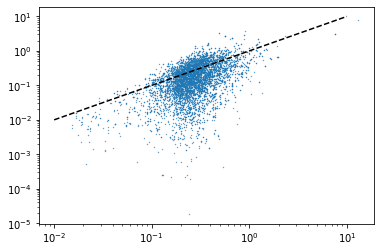

In [150]:
plt.scatter(std,z,s=0.1)
plt.plot(np.logspace(-2,1),np.logspace(-2,1),c="black",linestyle="--")
plt.yscale("log")
plt.xscale("log")


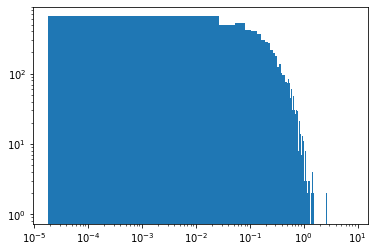

In [156]:
_= plt.hist(z,bins=300)
#plt.xlim(0,1)
plt.xscale("log")
plt.yscale("log")

In [99]:
cProfile.run("Ytest_pred_arr_2 = np.vstack(Ytest_predict).T")

         50 function calls (48 primitive calls) in 0.002 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_2d)
        1    0.000    0.000    0.002    0.002 <__array_function__ internals>:2(concatenate)
        1    0.000    0.000    0.002    0.002 <__array_function__ internals>:2(vstack)
        1    0.000    0.000    0.002    0.002 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 multiarray.py:148(concatenate)
        1    0.000    0.000    0.000    0.000 shape_base.py:207(_arrays_for_stack_dispatcher)
        1    0.000    0.000    0.000    0.000 shape_base.py:218(_vhstack_dispatcher)
        1    0.000    0.000    0.002    0.002 shape_base.py:222(vstack)
        1    0.000    0.000    0.000    0.000 shape_base.py:77(_atleast_2d_dispatcher)
        1    0.000    0.000    0.000    0.000 shape_base.py:81(atleast_2d)
     

In [91]:
Ytest_pred_arr.shape

(5676, 16)

In [77]:
Ytest_predict

[array([28.85642404, 21.43166309, 25.90917912, ..., 26.27594175,
        25.32492778, 26.63795367]),
 array([28.93368911, 21.43770239, 25.77790438, ..., 26.36408385,
        25.98256076, 26.6051287 ]),
 array([28.84623697, 21.55214696, 26.03742927, ..., 26.16851735,
        26.10633477, 26.56136771]),
 array([28.9454782 , 21.57454439, 25.86642631, ..., 26.20618799,
        25.92779018, 26.67656671]),
 array([28.96816858, 21.52131212, 25.94151753, ..., 26.43166807,
        25.6996471 , 26.65496561]),
 array([28.98405291, 21.52432182, 25.81195925, ..., 26.04872971,
        26.07736105, 26.56986235]),
 array([29.06818136, 21.4761263 , 26.35923883, ..., 26.20353751,
        25.99142286, 26.6238453 ]),
 array([28.97420428, 21.46431715, 25.93428261, ..., 26.25708842,
        26.17595207, 26.60960543]),
 array([29.06685872, 21.52113331, 25.95387502, ..., 26.26201608,
        25.75742888, 26.55718367]),
 array([29.08429103, 21.4741021 , 26.03703136, ..., 26.42867613,
        25.78474114, 26.54

In [10]:
mean_absolute_error(Ytest_predict,Ytest)

NameError: name 'mean_absolute_error' is not defined

In [46]:
Xtest.shape

(5676, 8640)

In [ ]:
np.std(Ytest_predict,axis=0)

In [ ]:
np.mean(Ytest_predict,axis=0)

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [36]:
mean_absolute_error(np.mean(Ytest_predict,axis=0),Ytest)

75.36458217326111

In [37]:
np.mean(Ytest_predict,axis=0)

array([ 62.22064019, 106.04607908, 103.43052958, ...,  93.77745888,
        82.44643906, 116.03518078])

In [23]:
model.n_estimators

16

In [56]:
sum(1,2,3,4)

TypeError: sum() takes at most 2 arguments (4 given)